In [27]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
%cd /content/gdrive/MyDrive/Maryland

/content/gdrive/MyDrive/Maryland


In [29]:
# !pip install -qr requirements.txt

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense,Lambda,Reshape,Conv1DTranspose, Conv1D,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from models import encoder, decgen, discriminator, VAE, VAEGAN

# Load and Define Data

In [31]:
# Load data and drop the state
train_df = pd.read_csv('/content/gdrive/MyDrive/Maryland/data/TrainValTest/train_only.csv', index_col=0)#.drop(["ST"], axis=1)
test_df = pd.read_csv('/content/gdrive/MyDrive/Maryland/data/TrainValTest/test_only.csv', index_col=0)#.drop(["ST"], axis=1)
# Make puma in range 0 to 4 (original pumas are 1201, 1202, 1203, 1204)
train_df['PUMA'] = train_df['PUMA'].apply(lambda x: x - 1201)
test_df['PUMA'] = test_df['PUMA'].apply(lambda x: x - 1201)
# To numpy arrays 
train = train_df.values
test = test_df.values
df = train_df

In [32]:
df.shape

(13507, 11)

# Data Preprocessing

In [33]:

X_train,X_test=train_test_split(df,test_size=200)

In [34]:
minmax=MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [35]:
def fit_batchsize(X,batch_size):
    n_size = (len(X)//batch_size)*batch_size
    X = X[0:n_size]

    return X
batch_size = 10
X_train = fit_batchsize(X_train, batch_size)
X_test = fit_batchsize(X_test, batch_size)

In [36]:
X_train=X_train.astype(np.float32)

# Define VAE-GAN Model

In [37]:
# class Sampling(layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# def encoder(latent_dim=2):
#     x = keras.Input(shape=(11,))
#     model = layers.Reshape((11,1))(x)
#     model = layers.Conv1D(12,3, activation="relu", strides=1, padding="same")(model)
#     model = layers.Conv1D(24,3,activation="relu", strides=1, padding="same")(model)
#     model = layers.Flatten()(model)
#     z_mean = layers.Dense(latent_dim, name="z_mean")(model)
#     z_log_var = layers.Dense(latent_dim, name="z_log_var")(model)
#     z = Sampling()([z_mean, z_log_var])
#     meansigma = keras.Model(x, [z_mean, z_log_var, z])
#     return meansigma

# def decgen(latent_dim=2):
#     x = keras.Input(shape=(latent_dim,))
#     model = layers.Dense(11 * 24, activation="relu")(x)
#     model = layers.Reshape((11, 24))(model)
#     model = layers.Conv1DTranspose(24, 3, activation="relu", strides=1, padding="same")(model)
#     model = layers.Conv1DTranspose(12, 3, activation="relu", strides=1, padding="same")(model)
#     model = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(model)
#     model = layers.Reshape((11,))(model)
#     model = keras.Model(x, model)
#     return model
    

# def discriminator():
#     x = keras.Input(shape=(11,))
#     model = layers.Reshape((11,1))(x)
#     model = layers.Conv1D(12,3, activation="relu", strides=1, padding="same")(model)
#     model = layers.Conv1D(24,3,activation="relu", strides=1, padding="same")(model)
#     model = layers.Flatten()(model)
#     model = layers.Dense(1, activation="sigmoid")(model)
#     output= keras.Model(x, model)
#     return output

# class VAE(keras.Model):
#     def __init__(self, encoder, decoder, **kwargs):
#         super(VAE, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder

#     def train_step(self, data):
#         if isinstance(data, tuple):
#             data = data[0]
#         with tf.GradientTape() as tape:
#             z_mean, z_log_var, z = encoder(data)
#             reconstruction = decgen(z)
#             reconstruction_loss = tf.reduce_mean(
#                 keras.losses.binary_crossentropy(data, reconstruction)
#             )
#             reconstruction_loss *= 11
#             kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
#             kl_loss = tf.reduce_mean(kl_loss)
#             kl_loss *= -0.5
#             total_loss = reconstruction_loss + kl_loss
#         grads = tape.gradient(total_loss, self.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
#         return {
#             "loss": total_loss,
#             "reconstruction_loss": reconstruction_loss,
#             "kl_loss": kl_loss,
#         }

# class VAEGAN(keras.Model):
    
#   # initialize models with latent dimensions
#   def __init__(self, disc, gen, latent_dim=2):
#     super(VAEGAN, self).__init__()
#     self.discriminator = disc
#     self.generator = gen
#     self.latent_dim = latent_dim
  
#   # compile with optimizers and loss function
#   def compile(self, optD, optG, loss_fn):
#     super(VAEGAN, self).compile()
#     self.optD = optD
#     self.optG = optG
#     self.loss_fn = loss_fn
    
#   # custom training function
#   def train_step(self, real_data):
#     if isinstance(real_data, tuple):
#       real_data = real_data[0]
    
#     # get current batch size
#     bs = tf.shape(real_data)[0]
#     z = tf.random.normal(shape=(bs, self.latent_dim))
#     fake_data = self.generator(z)
    
#     # combine real and fake images in a single vector along with their labels
#     combined_data = tf.concat([real_data, fake_data], axis=0)
#     labels = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)
    
#     # train your discriminator
#     with tf.GradientTape() as tape:
#       preds = self.discriminator(combined_data)
#       d_loss = self.loss_fn(labels, preds)
#       grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
#       self.optD.apply_gradients(zip(grads, self.discriminator.trainable_weights))
    
#     # misleading labels for generator
#     misleading_labels = tf.ones((bs, 1))
#     z = tf.random.normal(shape=(bs, self.latent_dim))
    
#     # train your generator
#     with tf.GradientTape() as tape:
#       fake_preds = self.discriminator(self.generator(z))
#       g_loss = self.loss_fn(misleading_labels, fake_preds)
#       grads = tape.gradient(g_loss, self.generator.trainable_weights)
#       self.optG.apply_gradients(zip(grads, self.generator.trainable_weights))
#     return {"d_loss": d_loss, "g_loss": g_loss}
# # create GAN model using already built D and G

In [38]:
encoder = encoder()
decgen = decgen()
vae = VAE(encoder, decgen)
vae.compile(optimizer=keras.optimizers.Adam())
discriminator = discriminator()
gan = VAEGAN(discriminator, decgen)
# compile your model with loss and optimizers
gan.compile(
    keras.optimizers.Adam(),
    keras.optimizers.Adam(),
    keras.losses.BinaryCrossentropy(from_logits=True))

In [39]:
hist_vae=vae.fit(X_train,X_train, epochs=20)

Epoch 1/20


TypeError: ignored

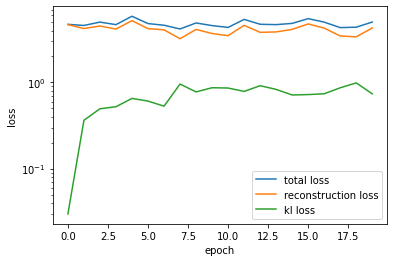

In [ ]:
plt.figure()
plt.semilogy(hist_vae.history['loss'],label='total loss')
plt.semilogy(hist_vae.history['reconstruction_loss'],label='reconstruction loss')
plt.semilogy(hist_vae.history['kl_loss'],label='kl loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [ ]:
hist_gan=gan.fit(X_train,epochs=100)

Epoch 1/100
135/135 [==============================] - 2s 3ms/step - d_loss: 0.6883 - g_loss: 0.6760
Epoch 2/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6576 - g_loss: 0.7886
Epoch 3/100
135/135 [==============================] - 0s 4ms/step - d_loss: 0.6762 - g_loss: 0.7795
Epoch 4/100
135/135 [==============================] - 1s 4ms/step - d_loss: 0.5954 - g_loss: 0.8071
Epoch 5/100
135/135 [==============================] - 0s 4ms/step - d_loss: 0.5831 - g_loss: 1.1942
Epoch 6/100
135/135 [==============================] - 0s 4ms/step - d_loss: 0.4766 - g_loss: 1.0477
Epoch 7/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.4941 - g_loss: 1.5474
Epoch 8/100
135/135 [==============================] - 0s 4ms/step - d_loss: 0.8147 - g_loss: 0.6480
Epoch 9/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6470 - g_loss: 0.7390
Epoch 10/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6407 - g_lo

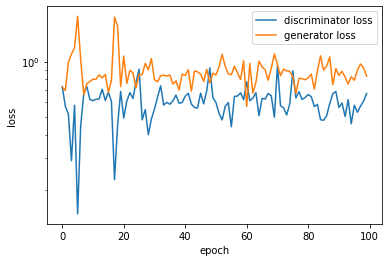

In [ ]:
plt.figure()
plt.semilogy(hist_gan.history['d_loss'],label='discriminator loss')
plt.semilogy(hist_gan.history['g_loss'],label='generator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [ ]:
z_mean, z_log_var, z = encoder(X_train)
generated_data=decgen(z)
generated_data

<tf.Tensor: shape=(4300, 11), dtype=float32, numpy=
array([[4.9816808e-01, 7.4900717e-02, 3.1332275e-01, ..., 1.6626179e-02,
        1.4766433e-28, 2.0667710e-13],
       [3.3152574e-01, 1.6545743e-02, 4.7755620e-01, ..., 2.5015923e-11,
        8.0232354e-27, 6.5414382e-18],
       [9.7221583e-02, 8.1802905e-03, 7.7373374e-01, ..., 9.9999940e-01,
        5.6553063e-36, 1.4839617e-13],
       ...,
       [9.8046082e-01, 4.6217458e-05, 6.3207680e-01, ..., 9.3760174e-38,
        5.7967548e-36, 7.1290477e-27],
       [9.1806716e-01, 2.9213619e-01, 2.0058697e-01, ..., 8.1929564e-04,
        6.6340614e-27, 6.7740063e-13],
       [5.0198215e-01, 8.5301548e-02, 3.1385285e-01, ..., 1.6135561e-09,
        1.5022693e-26, 1.5030565e-16]], dtype=float32)>

In [ ]:
z_mean, z_log_var, z = encoder(X_test)
generated_data=decgen(z)
X_test=tf.convert_to_tensor(X_test)

fin_X_test=X_test

for i in range(100):
    z_mean, z_log_var, z = encoder(X_test)
    generated_data=tf.concat([generated_data,decgen(z)],0)

print(generated_data)


tf.Tensor(
[[2.56747901e-02 3.46530348e-01 2.90551782e-02 ... 3.37091851e-26
  8.70326760e-33 5.21133298e-25]
 [9.91452575e-01 8.07771630e-06 6.92966878e-01 ... 0.00000000e+00
  1.96607188e-36 3.89281238e-28]
 [6.96065485e-01 9.79233384e-02 3.09725940e-01 ... 2.84715828e-31
  7.72818475e-34 4.43764118e-24]
 ...
 [2.53918767e-03 4.39726233e-01 1.02509260e-02 ... 7.97035726e-30
  8.45407085e-36 2.57546643e-28]
 [9.36065555e-01 2.53327131e-01 2.34070092e-01 ... 2.13221584e-12
  8.50895448e-26 3.45275829e-16]
 [9.95744407e-01 1.42887875e-05 5.32326400e-01 ... 3.10824239e-35
  7.16244577e-33 9.21576399e-25]], shape=(20200, 11), dtype=float32)


In [ ]:
generated_data=minmax.inverse_transform(generated_data)
generated_data

array([[2.10269916e+00, 4.07918209e+00, 2.58591086e+00, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [5.96581030e+00, 2.00004847e+00, 6.16740522e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [4.78426194e+00, 2.58754003e+00, 2.75656087e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       ...,
       [2.01015675e+00, 4.63835740e+00, 9.12332416e-01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [5.74426222e+00, 3.51996279e+00, 2.08322382e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [5.98297763e+00, 2.00008573e+00, 4.73770496e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01]])

In [ ]:
generated_data=np.round(generated_data)
generated_data

array([[2.000e+00, 4.000e+00, 3.000e+00, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [6.000e+00, 2.000e+00, 6.200e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [5.000e+00, 3.000e+00, 2.800e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       ...,
       [2.000e+00, 5.000e+00, 1.000e+00, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [6.000e+00, 4.000e+00, 2.100e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [6.000e+00, 2.000e+00, 4.700e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01]])

In [ ]:
generated_data=pd.DataFrame(generated_data)

In [ ]:
generated_data.to_csv('VAE-GAN reconstruction PUMA==1204.csv')